# CUSPX: Efficient GPU Implementations of Post-Quantum Signature SPHINCS+

## Abstract

- We introduce CUSPX (CUDA SPHINCS+), the first large-scale **parallel implementation** of SPHINCS+ capable of running across 10,000 cores.
  - CUSPX leverages a novel three-level parallelism framework, applying it to _algorithmic parallelism_, _data parallelism_, and _hybrid parallelism_.
  - CUSPX introduces parallel Merkle tree construction algorithms for arbitrary parallel scales and several load-balancing solutions, further enhancing performance.
- CUSPX achieves a single task’s signature generation latency of **0.67 ms**, demonstrating a 5,105× speedup over a single-thread version and an 18.50× speedup over the previous fastest implementation.


## 1. Introduction

Nowadays, the National Institute of Standards and Technology (NIST) has selected three DSAs for standardization : CRYSTALS-Dilithium, Falcon, and SPHINCS+.
Also, a KEM is selected for standardization: CRYSTALS-KYBER. According to the NIST’s recent presentation, the standardization of these algorithms is expected to be finalized in 2024.
Compared to the other three lattice-based algorithms, SPHINCS+ can offer more conservative security but with poorer performance. Therefore, it is necessary to optimizes the performance of $SPHINCS+$.

> **SPHINCS+** is the PQC stander until 2025.


### 1.1 Motivation

The reported maximum throughput of SPHINCS+-128s-simple is 80.65 signatures per second on an FPGA implementation, corresponding to 12.40 ms per signature and 14,285.71 verifications per second, or 0.07 ms per verification.

### 1.2 Challenges and Contributions

Our design faces three challenges.

- Large-scale parallel designs: Efficiently parallelizing $SPHINCS+$ on GPUs, with their many cores and poor single-core performance, is a challenging task.
- Hybrid parallel designs: Hybrid parallelism requires a trade-off between latency and throughput, which further complicates the design of parallel schemes.
- GPU efficient implementation: It is a challenge to make $SPHINCS+$ fully utilizes the hardware resources on the GPU.

> the challenges not close related to the $SPHINCS+$ algorithm itself. It is the all parallel computing challenges.


- We propose CUSPX (CUDA SPHINCS+), the first large-scale parallel implementation for standardized general-purpose HBS. Three parallel schemes are designed for various application scenarios: algorithmic parallelism, data parallelism, and hybrid parallelism. Our code will be open-sourced after the article is accepted.
- We present a three-level parallel framework: multi-tree, inter-node, and intra-node levels, which can be used individually or in combination. Merkle tree parallel construction algorithms for arbitrary parallel scales are proposed.
- We design a general-purpose hybrid parallel scheme for HBS. CUSPX understands task parallelism as a higher-level existence than the three-level parallel framework, that is, hybrid parallelism of CUSPX is a _four-level parallel framework_. Moreover, we design four kinds of load-balancing schemes for $WOTS+$ and two for $FORS$ trees.


## 2. Preliminaries

### 2.2 Review of SPHINCS+

| Terms          | Meanings                                             |
| -------------- | ---------------------------------------------------- |
| pk, sk, sig    | Public key, private key, and signature of $SPHINCS+$ |
| H, n           | A hash operation and its output size in bytes        |
| wotsPk, wotsSk | Secret key and public key of $WOTS+$                 |
| wotsSig        | Signature of $WOTS+$                                 |
| forsPk, forsSk | Secret key and public key of $FORS+$                 |
| forsSig        | Signature of $FORS+$                                 |
| h, d           | Height and number of layers of the hypertree         |
| h' = h/d       | Height of a single-layer tree                        |
| w              | Length of a Winternitz chain                         |
| len            | Number of n-byte strings in OTS                      |
| msg, m         | Message digest and its length in bytes for DSA       |
| hmsg, md       | Message and its digest for hash functions            |
| a, k           | Number and height of trees in $FORS$                 |
| addr           | A 32-byte data structure                             |
| OptRand        | A n-byte string used to counter side-channel attacks |


Table III shows the terms and their meanings of the SPHINCS+ algorithm. Let us illustrate the meaning of the parameter set with the example SPHINCS+-SHA-256-192f-simple. “SPHINCS+” is the prefix of all parameter sets. “SHA-256” indicates the hash function used. The number “128” represents the number of bits of parameter $n$. The letter after the number can be “f” or “s”, indicating the fast version or the small signature version, respectively. The term “robust” means bitmasks are used when performing hash functions. When bitmasks are not used, “robust” replaces “simple”.


### 2.3 Related Work

Table II summarises large-scale parallel work on HBSs. XMSS, LMS and SPHINCS.

| Work          | Inter-Tree | Inter-Node | Intra-Node | AP  | DP  | HP  |
| :------------ | :--------: | :--------: | :--------: | :-: | :-: | :-: |
| LMS [20]      |     ✗      |     ✓      |     ✓      |  ✓  |  ✓  |  ✗  |
| LMS [21]      |     ✗      |     ✓      |     ✓      |  ✓  |  ✓  |  ✗  |
| XMSS [22]     |     ✗      |     ✓      |     ✓      |  ✓  |  ✓  |  ✗  |
| SPHINCS [23]  |     ✓      |     ✓      |     ✓      |  ✓  |  ✓  |  ✗  |
| SPHINCS+ [24] |     ✓      |     ✓      |     ✓      |  ✗  |  ✗  |  ✓  |
| CUSPX         |     ✓      |     ✓      |     ✓      |  ✓  |  ✓  |  ✓  |


Wang et al. [22] apply a two-level parallel framework to XMSS on the GPU. The first level is **inter-node** parallelism, which distributes the computation across multiple nodes. The second level is **intra-node** parallelism, which distributes the computation within each node.

In addition, SPHINCS+ has an important structure, the XMSS tree. Optimisation schemes for the XMSS tree are still of reference significance. Overall, optimisation schemes can be divided into three categories:

- Vectorization technology such as AVX2 [29], [30] and NEON [31]
- Optimization of hardware-specific instructions such as those on Intel [32] and Cadence [33] processors
- Accelerator-specific optimizations such as those on FPGA [34]–[37], ASIC [38] and GPU [22]


Shen et al. [41] presented a high-throughput GPU implementation of Dilithium. From the aspects of individual operations, concurrent task processing, dynamic task scheduling and data transfer hiding, they performed comprehensive optimization.

> Here, it details the specific techniques used in parallel computing, including process synchronization, memory management, and load balancing strategies.


## 3 Design for parallelized SPHINCS+

This section studies parallel methods of SPHINCS+. Three parallel schemes are provided: algorithmic, data and hybrid parallelism. We call a single execution of keypair generation, signature generation or signature verification a “task”.


### 3.1 Algorithmic Parallelism

#### 3.1.1 Three-Level Parallel Framework

The three-level parallel framework of CUSPX is shown in Fig. 1. Level 1 is inter-tree parallelism, in which multiple Merkle trees are constructed in parallel. Level 2 is inter-node parallelism, in which nodes of the same layer within a single Merkle tree are generated in parallel. Level 3 is intra-node parallelism, in which a leaf node is generated in parallel.


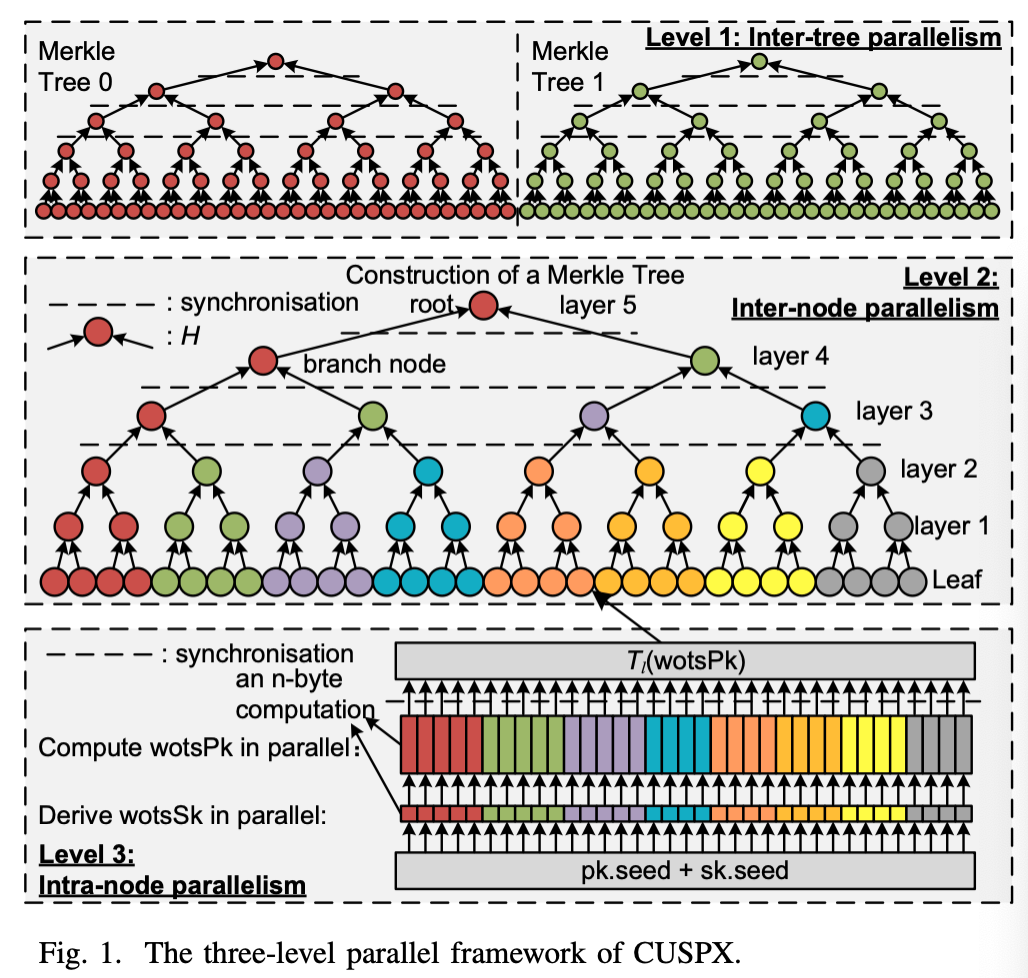


> IDEA: The level 2, which the parallelism the merkle trees, the number of parallelism threads maybe one important factor to the performance.
> Not the simple the more the better, here have one balance between the number of threads and the performance.
>
> when the threads task need to synchronize, the more threads, the more time cost. So too many threads will cause the performance decrease.


**Parallel efficiency**. Parallel efficiency **decreases** from level 1 to level 3 for two reasons. First, the proportion of inter-thread synchronization overhead increases as the number of levels increases. Second, the proportion of parallelize parts and the parallel scale decreases. Level 1 has no non-parallelize parts. Level 2 has two types of nodes, branch nodes and leaf nodes. Although the overhead of branch nodes is much less than that of leaf nodes, the parallelism of branch nodes decreases from bottom to top. In level 3, the hash function $T_l(wotsPk)$ cannot be parallelized and it takes a lot of time. Thus, the parallel efficiency is lower.


**Memory usage**. Levels 3 have the same memory footprint as the serial implementation, while level 2 requires more memory because all node values at a layer must be stored in memory before computation. When level 1 is used alone, the memory footprint is unchanged. But when level 1 is used with level 2, the memory footprint becomes more.


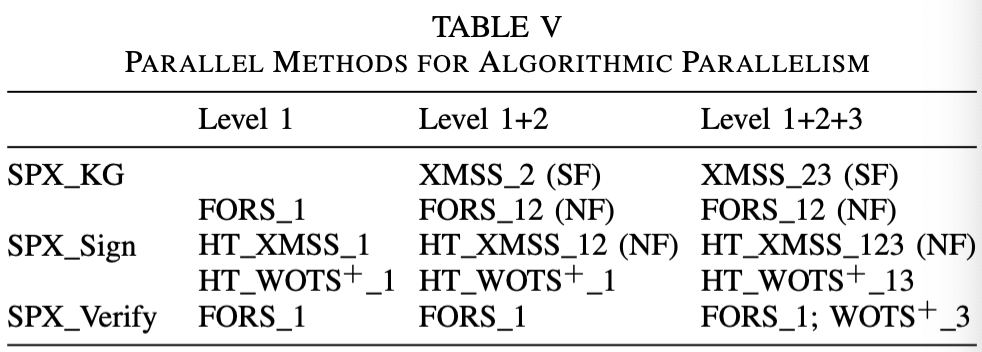


#### 3.1.2 Parallel WOTS+

WOTS+ consists of three functions: `wotsPkGen`, `wotsSign` and `wotsPkFromSig`. The parallel scheme for these functions is similar: $len_n$-byte computations can be computed in parallel. The standalone WOTS+ exists only in SPHINCS+ verifying (WOTS+\_3). The other two functions are used with multiple levels of parallelism.


#### 3.1.3 Parallel Merkle Tree

**Fig. 2** shows two schemes for parallel Merkle tree construction with three threads, where one colour represents a thread:

1. The **subtree-first** scheme constructs a power of 2 subtrees to minimise synchronization overhead.
2. The **node-first** scheme evenly distributes the node generation of each layer to achieve load balancing.


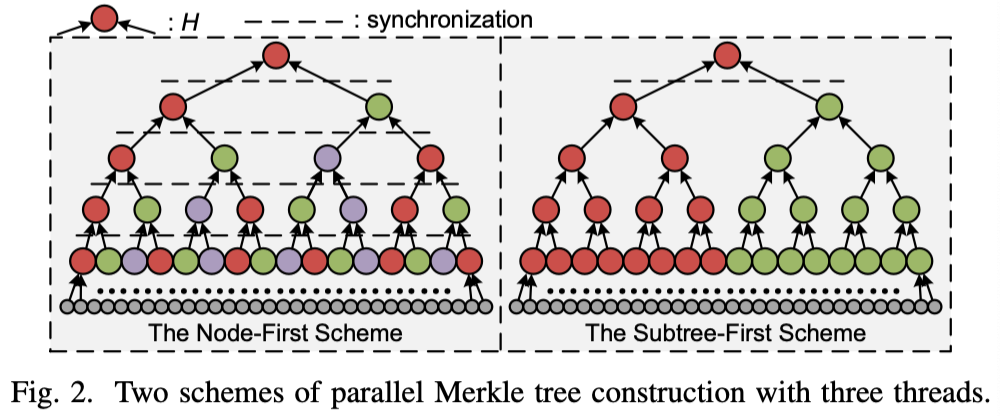


To avoid memory overlap when computing in parallel, the computation is performed as shown in **Fig. 3**. Eight blocks are used, each representing a contiguously stored leaf array. The computation proceeds as follows:

1. The thread synchronises
2. The memory is copied
3. The hash function is applied

Finally, the first node stored in the leaf array is the root node.


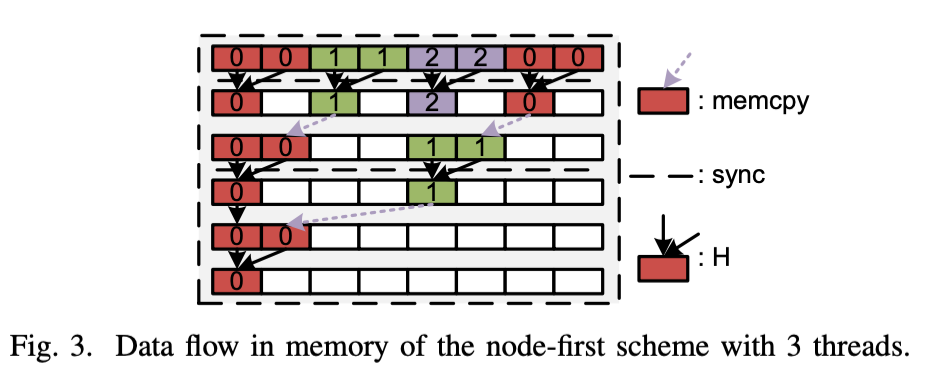


Both schemes have their advantages and disadvantages:

**Subtree-first scheme**:

- Requires only a small amount of memory, proportional to the number of subtrees
- Requires fewer synchronization operations, which can improve performance

**Node-first scheme**:

- More efficient in load balancing
- Easier to implement for irregular Merkle trees
- Easier to leverage GPU coalesced access technology (introduced in Section IV-B)

We will describe the application scheme according to the specific situation in the later parts.


#### 3.1.5 Parallelized FORS

We illustrate the parallel FORS scheme using FORS signing using parallelism of levels 1+2. **Fig. 4** shows our parallel design using node-first scheme, in which:

- Threads generate nodes sequentially
- Threads synchronise at each layer

The reason for choosing node-first scheme is that the number of FORS trees is not a power of 2, so **load balancing** is more important.


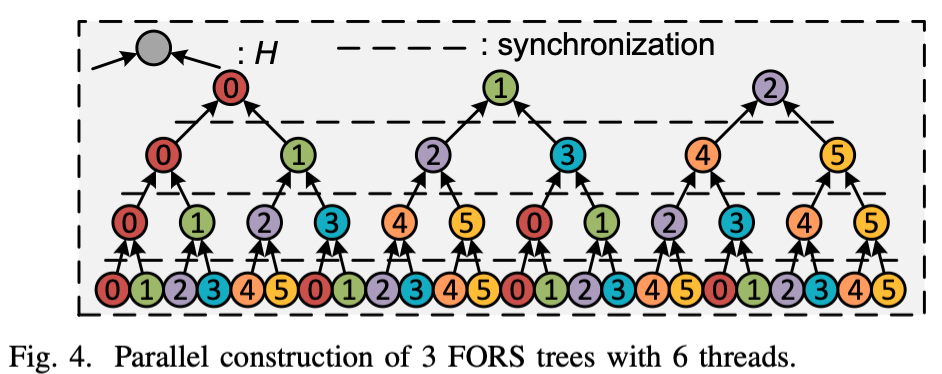


Algorithm 1. details the parallel FORS signing, which signs m to generate forsSig. Leaf node generation (lines 2-16) and Merkle tree construction (lines 18-32) are executed separately to facilitate Merkle tree construction.


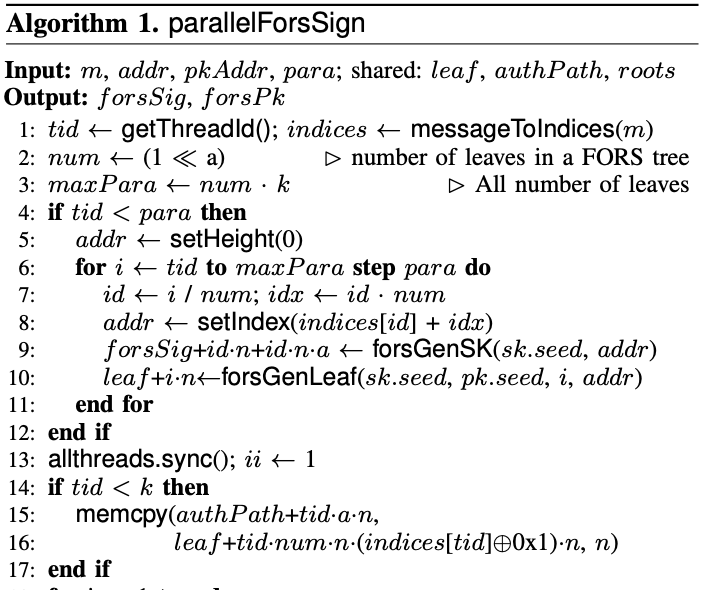


Line 1 initializes thread ID to `tid` and converts the message to an index array, `indices`.

The number of leaves in a single FORS tree and across all FORS trees is then retrieved. Line 4 guarantees that only `para` threads are employed.

Leaf node height and row indices are set in lines 5 and 8, respectively. Lines 6 and 7 distribute leaf generation across threads using the parallel scheme illustrated in Fig. 4.


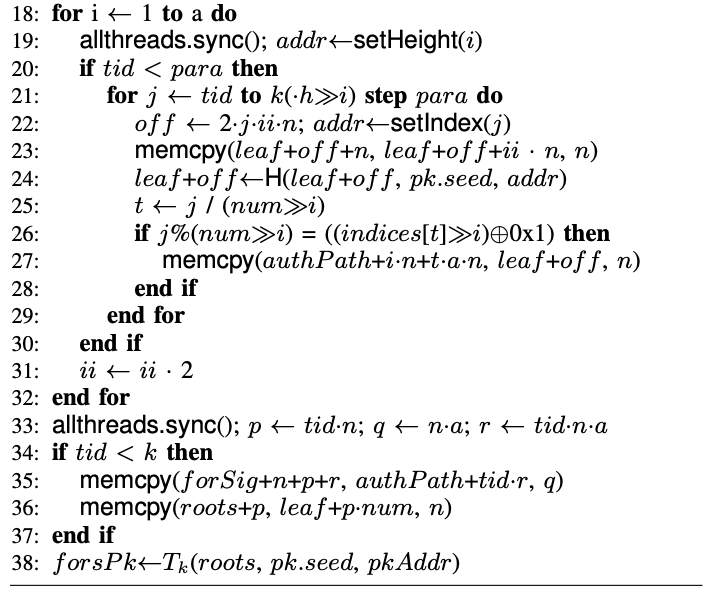


First, line 19 synchronizes all `para` threads before the computation of each layer begins. Then, line 21 distributes the computations of all nodes to all `para` threads in a round-robin way. After setting the index (lines 19 and 22) and obtaining the data (line 23), the hash function $H$ is performed. Finally, the loop terminates when the number of layers reaches the highest layer, $a$ (line 18). At each layer $i$, the variable `off` is used to avoid memory overlap (lines 22, 23, 24 and 27).


### 3.3 Hybrid Parallelism

Hybrid parallelism refers to multiple groups performing multiple $tasks$ in parallel, one $task$ per group.
We understand the parallelism of tasks as a higher level existence than the three-level parallel framework, that is, hybrid parallelism of CUSPX is **four-level parallel framework**.


#### 3.3.1 Parallel WOTS+

The maximum parallelism of the two functions is $len$. If the maximum parallelism is insufficient to support multiple $tasks$ with $len$ parallelism, load balancing schemes are needed. We consider four kinds of schemes.

Local load-balancing scheme. The $\text{len}$ $n$-byte computations of each group are divided equally among the threads. This allows each group to compute independently, with maximum load imbalance but no synchronization overhead.

Global load-balancing scheme. All n-byte computations are evenly distributed to all threads across all groups. This scheme requires global synchronization, but it effectively avoids load imbalance.


Working pool scheme. The scheme works by placing all $n$-byte computations of a group in a working pool. When a thread completes a chain, it checks the pool for unfinished chains. If it finds one, it computes that chain. Otherwise, the thread terminates. The working pool is shared across groups, which introduces an intra-group synchronization issue. Compared to global sharing, this scheme still suffers from load imbalance.

Pre-allocation scheme. The core of this scheme is to determine which $n$-byte computations should be executed by which thread through pre-calculation. By counting the accumulated length of hash chains for each thread, it can be determined which $n$-byte computations each thread should execute.


#### 3.3.3 Parallel FORS

Figure 5 depicts the local and global load-balancing schemes employed within FORS verifying, where each block represents a FORS tree. The construction of seven FORS trees constitutes a single task and seven such tasks are executed by 25 threads.

In the local load-balancing scheme, the 25 threads are partitioned into seven groups, each responsible for constructing 7 FORS trees (a single task). Threads are assigned uniformly to each group, with surplus threads remaining idle (21-24). This results in three threads per group, distributing the FORS trees evenly. Consequently, one thread processes three trees, while the remaining two handle two trees each.

In the global load-balancing scheme, all FORS trees are distributed across the 25 threads, with each thread processing a maximum of two trees. This scheme surpasses the local scheme as it eliminates the requirement for any thread to handle three trees.


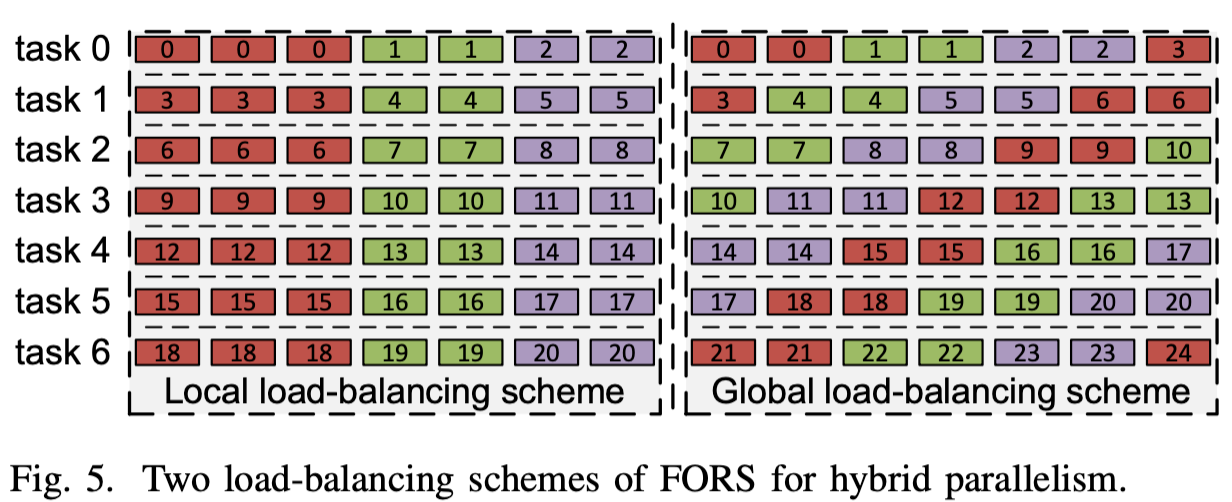


## 4 Implementation on The GPU

GPU optimizations in CUSPX can be divided into three main categories:

1. **Instruction Optimisations**

   - Focuses on instruction cycle reduction
   - Optimizes instruction order

2. **Memory Access Optimisations**

   - Improves efficient access to various GPU memory levels

3. **Parallel Optimisations**
   - Enhances coordination of computing components
   - Optimizes parallel computing efficiency


### 4.1 Instruction Optimizations

**Synchronization**
We use `cooperative_groups` for global memory synchronization and `syncthreads()` for shared memory synchronization.

**Kernel function fusion**
We merge multiple kernels of a cryptographic function into one kernel, thereby reducing overheads such as startup and data transfer.


### 4.2 Memory Access Optimizations

**_Coalesced access_**
As mentioned in Section III-A5, the working theory of coalesced access is that if threads in a warp handle the same $128$-byte chunk and the chunk is aligned to the $128$-byte cache line, fewer cache transactions are needed compared to random access memory.


### 4.3 Parallel Optimizations

CUSPX uses the general scheme described in the right figure, treating multiple tasks as one large task to be processed in a data domain.

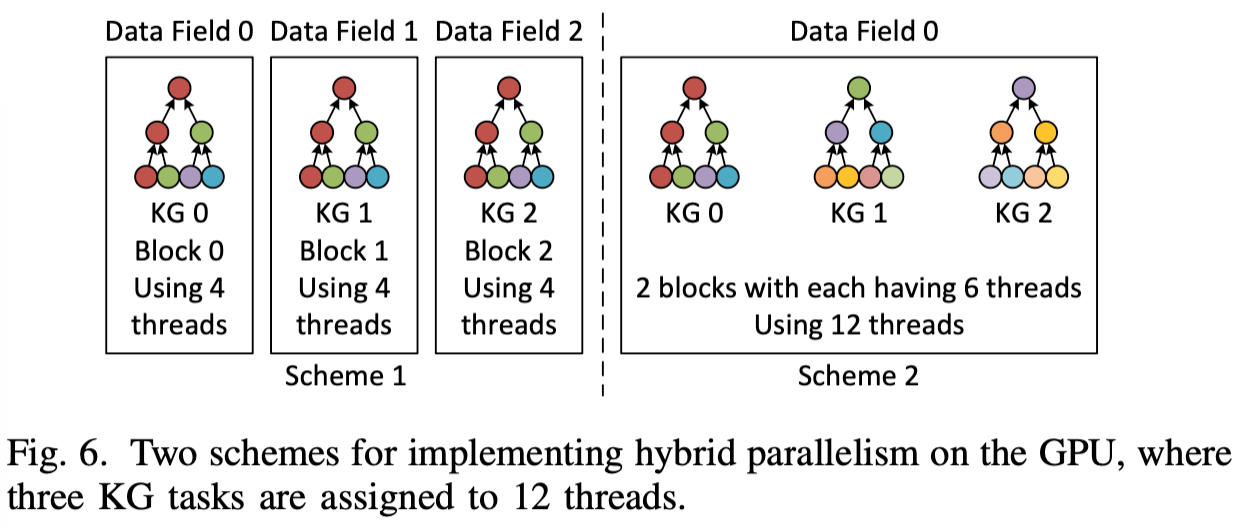


> This optimization not like the improve of the implementation of the algorithm itself, it like the implementation notes about the experimenting.


## 5. Evaluation

### 5.1 Evaluation Criteria and Setup

Performance is evaluated in terms of throughput and latency. Latency, expressed in milliseconds ($\text{ms}$), encompasses both data transfer time between CPUs and GPUs and GPU kernel execution times. Throughput is measured as the number of completed tasks per second ($\text{tasks}/\text{sec}$).


### 5.2 Tests of Components

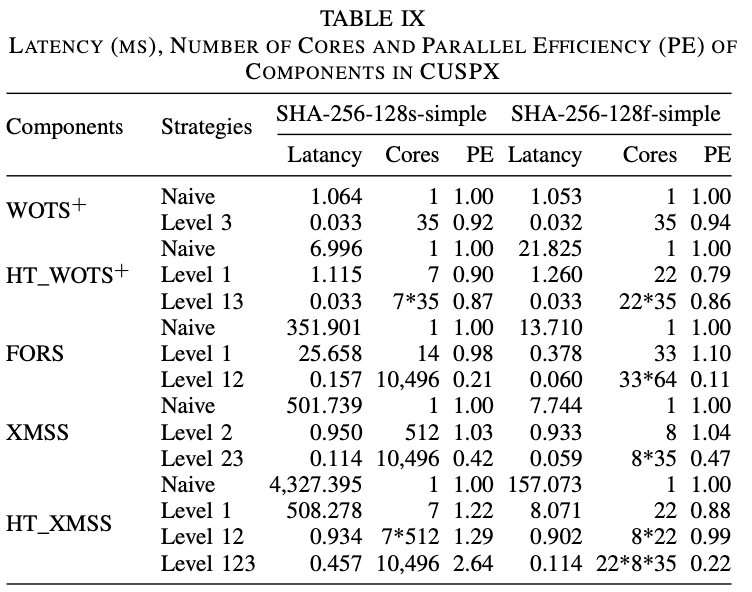


### 5.3 Tests of Algorithmic Parallelism

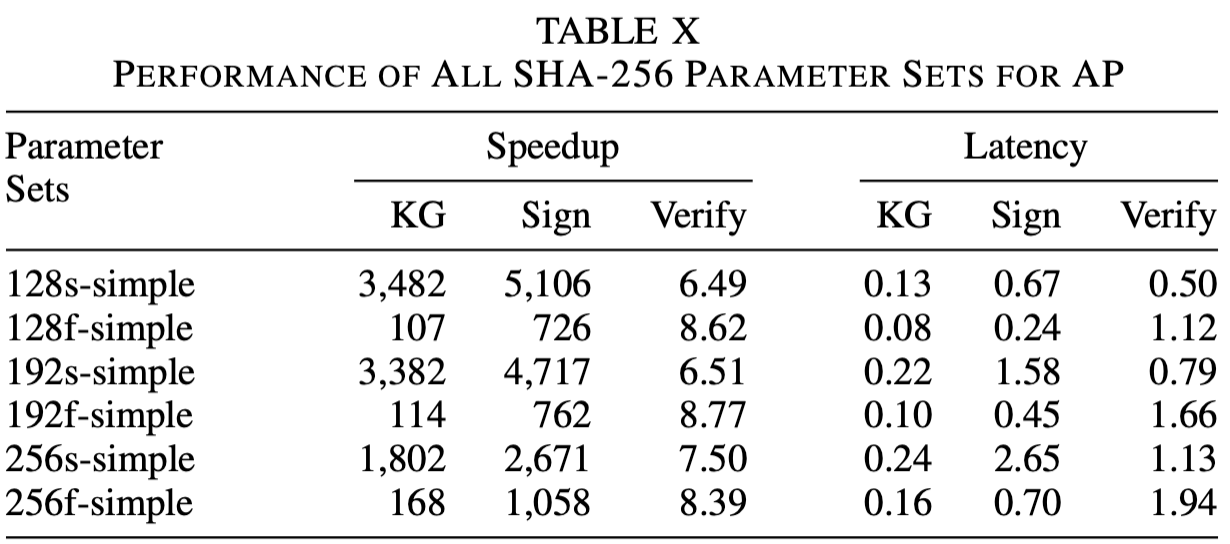


### 5.4 Test of Data Parallelism

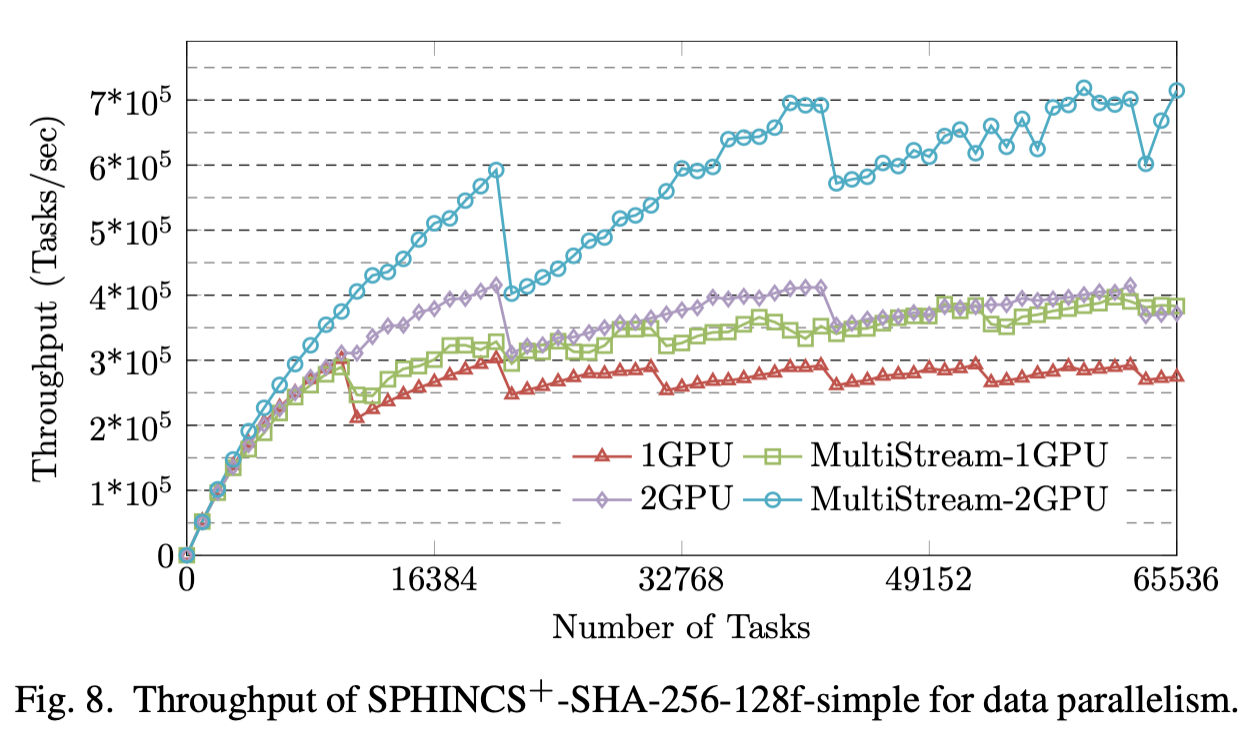


### 5.6 Comparison with Related Work

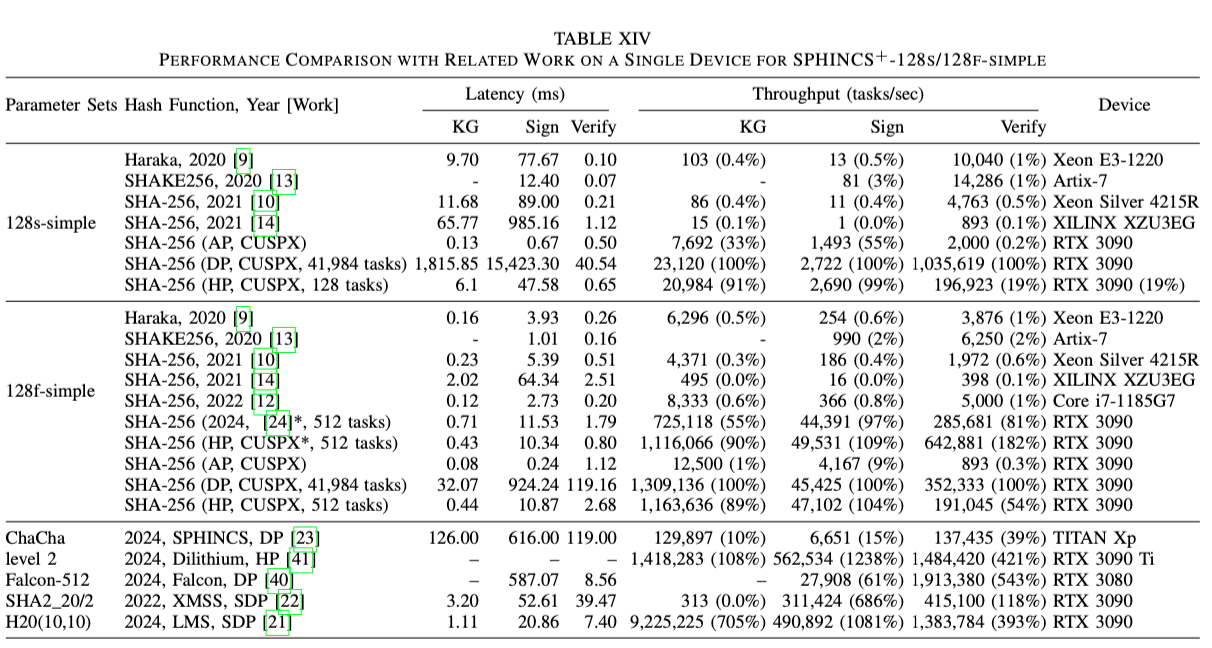